In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from load_data import *
from helpers import *

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import shap

In [2]:
# Load data
X_train, X_test, X_val, y_train, y_test, y_val = load_data()


------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blanke

In [3]:
X_train = pd.concat((X_train,X_val)).reset_index(drop = True)
y_train = pd.concat((y_train,y_val)).reset_index(drop = True)

In [4]:
# define metric
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  r2 = r2.numpy()
  return r2

score = make_scorer(R_squared, greater_is_better=True)


In [5]:
# gridsearch 
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit=score,
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred
  
  

In [ ]:
np.random.seed(123)
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.1, 0.5, 0.9],
    'max_depth': [3,10,50],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'subsample': [0.5,0.7,0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

In [7]:
model.best_score_

0.665197381001297

In [8]:
model.best_params_

{'colsample_bytree': 0.9,
 'gamma': 1,
 'max_depth': 3,
 'n_estimators': 500,
 'reg_lambda': 10,
 'subsample': 0.9}

In [41]:
model.param_grid

{'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

In [21]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1

FOLD  1
Train:  0.8024456880055812 0.08809023175192375 0.22325297005565686
Validation:  0.6423473600046352 0.094263637312724 0.2245718485880479
Test:  0.6330447219569217 0.14690261330545543 0.2835577124912234
FOLD  2
Train:  0.7953263603347384 0.08892993349532169 0.2230763069241064
Validation:  0.6603565751680566 0.09090720014649831 0.22527800253532715
Test:  0.6194419855806591 0.14690261330545543 0.2835577124912234
FOLD  3
Train:  0.7946432824407905 0.08970126902968946 0.22354618970217843
Validation:  0.6719172925478007 0.08782226723273953 0.22339965968109463
Test:  0.6171689313330095 0.14690261330545543 0.2835577124912234
FOLD  4
Train:  0.7921310503810065 0.09063479115267047 0.22408803460629453
Validation:  0.7005910162878157 0.08408642069538616 0.2212312596410821
Test:  0.6242977467212724 0.14690261330545543 0.2835577124912234
FOLD  5
Train:  0.7988693687377773 0.08927144159972301 0.22362080660336459
Validation:  0.650774660998177 0.08954238642045838 0.22310105155487905
Test:  0.62

In [42]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1
    if c == 5:
        break

FOLD  1
Train:  0.8024456880055812 0.08809023175192375 0.22325297005565686
Validation:  0.6423473600046352 0.094263637312724 0.2245718485880479
Test:  0.6330447219569217 0.14690261330545543 0.2835577124912234
FOLD  2
Train:  0.7953263603347384 0.08892993349532169 0.2230763069241064
Validation:  0.6603565751680566 0.09090720014649831 0.22527800253532715
Test:  0.6194419855806591 0.14690261330545543 0.2835577124912234
FOLD  3
Train:  0.7946432824407905 0.08970126902968946 0.22354618970217843
Validation:  0.6719172925478007 0.08782226723273953 0.22339965968109463
Test:  0.6171689313330095 0.14690261330545543 0.2835577124912234
FOLD  4
Train:  0.7921310503810065 0.09063479115267047 0.22408803460629453
Validation:  0.7005910162878157 0.08408642069538616 0.2212312596410821
Test:  0.6242977467212724 0.14690261330545543 0.2835577124912234


In [355]:
X_train_no,X_test_no,_,_,_,_ = load_data(for_dendro=True, standardize=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

In [332]:
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_no.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_no[i].values.reshape((X_test_no[i].values.shape[0],1,1))
    
    
    
    return values

In [260]:
X_test_no.loc[:,["bedrooms_1", "bedrooms_2", "accommodates", "beds", "room_type_Entire_home/apt", "room_type_Private_room",
                     "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                     "property_type_Entire_residential_home", "property_type_Entire_rental_unit", "property_type_Others"]].mean()

bedrooms_1                               0.688433
bedrooms_2                               0.180970
accommodates                             3.024254
beds                                     1.826493
room_type_Entire_home/apt                0.498134
room_type_Private_room                   0.490672
bath_number_1                            0.675373
bath_number_2                            0.279851
bath_kind_Shared                         0.244403
bath_kind_Private                        0.152985
bath_kind_Normal                         0.602612
property_type_Entire_residential_home    0.139925
property_type_Entire_rental_unit         0.250000
property_type_Others                     0.552239
dtype: float64

In [364]:
X_test_no["accommodates"].argmin()

8

In [369]:
print(X_test_no.loc[[8,588],["bedrooms_1", "bedrooms_2", "accommodates", "beds", "room_type_Entire_home/apt", "room_type_Private_room",
                     "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                     "property_type_Entire_residential_home", "property_type_Entire_rental_unit", "property_type_Others"]].T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  8   &  588 \\
\midrule
bedrooms\_1                            &  1.0 &  0.0 \\
bedrooms\_2                            &  0.0 &  1.0 \\
accommodates                          &  1.0 &  6.0 \\
beds                                  &  1.0 &  2.0 \\
room\_type\_Entire\_home/apt             &  0.0 &  1.0 \\
room\_type\_Private\_room                &  1.0 &  0.0 \\
bath\_number\_1                         &  1.0 &  1.0 \\
bath\_number\_2                         &  0.0 &  0.0 \\
bath\_kind\_Shared                      &  0.0 &  0.0 \\
bath\_kind\_Private                     &  1.0 &  0.0 \\
bath\_kind\_Normal                      &  0.0 &  1.0 \\
property\_type\_Entire\_residential\_home &  0.0 &  1.0 \\
property\_type\_Entire\_rental\_unit      &  0.0 &  0.0 \\
property\_type\_Others                  &  1.0 &  0.0 \\
\bottomrule
\end{tabular}



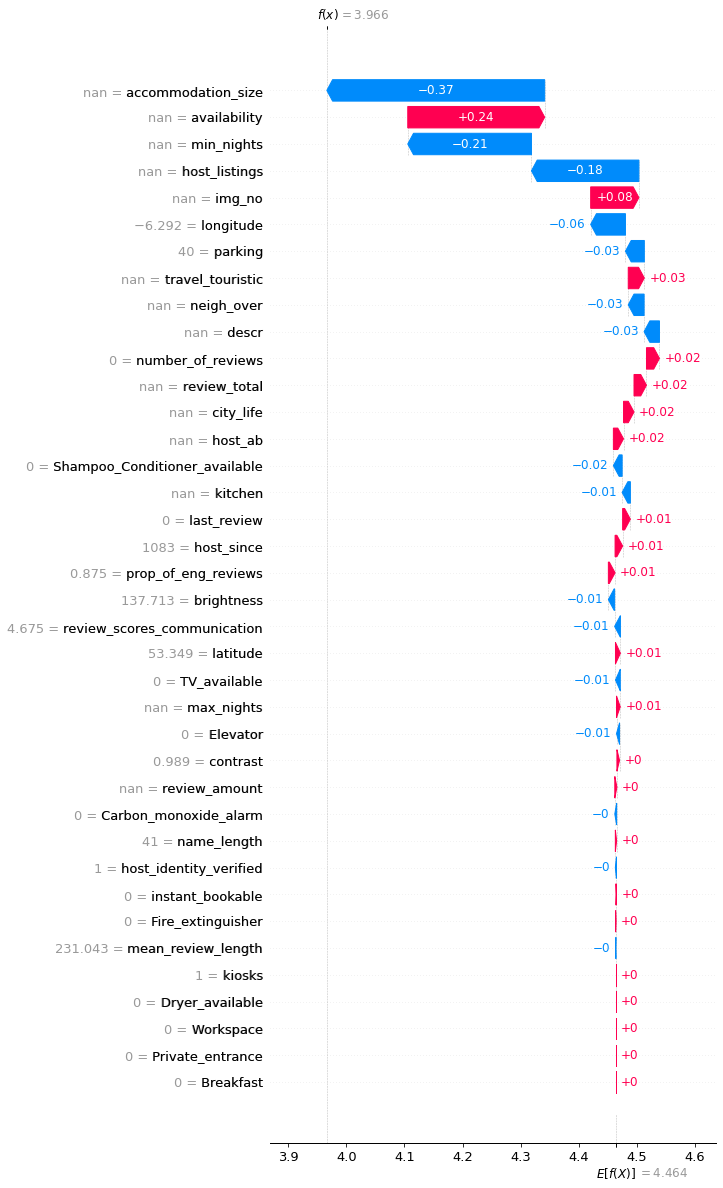

In [365]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[8], max_display = 50)

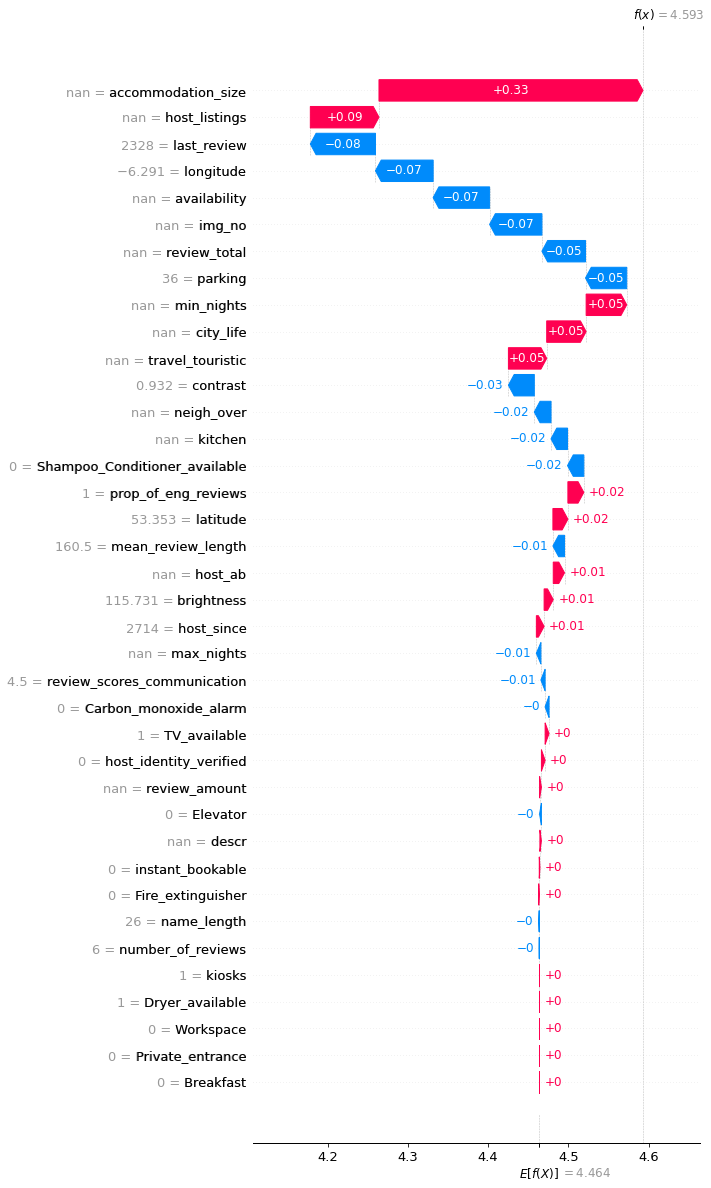

In [370]:
explainer = shap.Explainer(model_fold)
shap_values = explainer(X_test)
shap_values = get_aggr_shap(shap_values)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[588], max_display = 50)

In [311]:
X_test_no.shape

(1321, 149)

All-NaN slice encountered


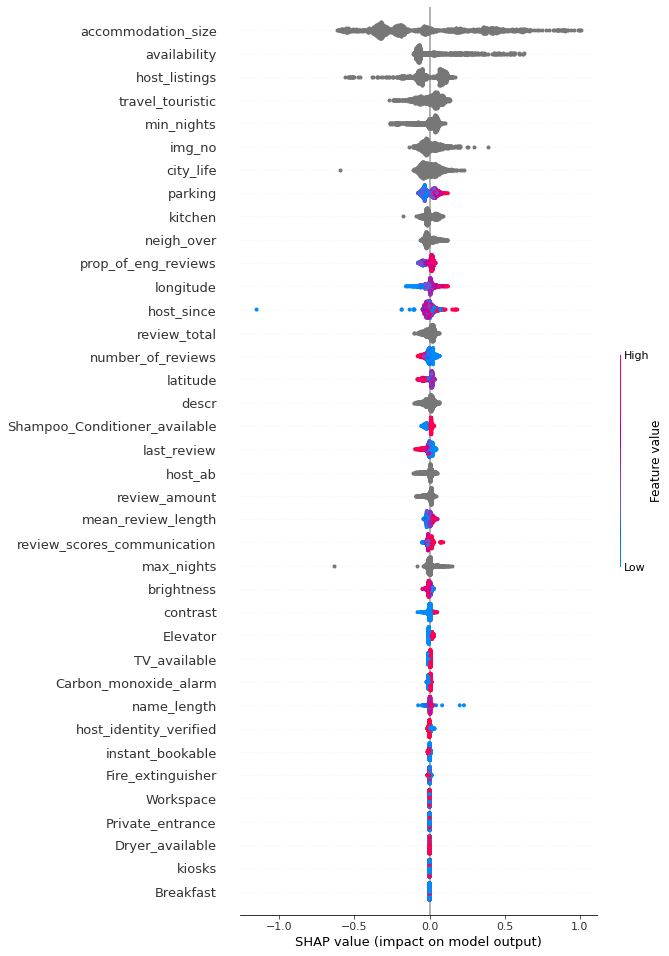

In [371]:
shap.plots.beeswarm(shap_values, max_display=50)


## Adjusted $R^2$

In [372]:
1 - (1-model_fold.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.6045239439171288

### Save best model

In [373]:
model_fold.save_model("xgBoost_models/model_pca.json")

In [376]:
# load
opt_param = {'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

model_new = xgb.XGBRegressor(**opt_param)
model_new.load_model("xgBoost_models/model_pca.json")

# Without decorrelation

In [377]:
# Load data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(for_dendro=True)


------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

In [378]:
X_train = pd.concat((X_train,X_val)).reset_index(drop = True)
y_train = pd.concat((y_train,y_val)).reset_index(drop = True)

In [379]:
# define metric
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  r2 = r2.numpy()
  return r2

score = make_scorer(R_squared, greater_is_better=True)


In [380]:
# gridsearch 
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit=score,
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred
  
  

In [381]:
np.random.seed(123)
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.1, 0.5, 0.9],
    'max_depth': [3,10,50],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'subsample': [0.5,0.7,0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min
[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.9min
[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   3.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   1.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   1.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   1.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 2.0min
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.3s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 2.1min
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   1.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   1.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   1.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   1.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.3min
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   6.3s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   6.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   6.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   6.3s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.1s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   6.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   5.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   4.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   4.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   4.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   4.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   4.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   4.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   4.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   4.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   4.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   4.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   5.1s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   5.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   5.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   5.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   5.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   5.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   5.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   5.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   6.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   6.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   6.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   6.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   5.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   4.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   4.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   4.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   4.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   4.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   4.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   4.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=   8.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=   9.0s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=   9.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=   9.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=   9.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=   8.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=   9.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=   9.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=   9.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=   9.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  11.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  10.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  10.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  10.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  10.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  10.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  10.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  11.0s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  10.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  10.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  10.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=   9.9s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  10.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  10.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  10.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  11.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  11.0s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   9.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   9.3s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  10.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  10.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  10.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  10.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  11.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  11.2s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  11.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  11.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  11.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  11.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  10.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   9.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  10.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   9.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   9.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   9.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   9.0s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   9.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   9.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   9.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   9.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   9.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  22.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  22.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  22.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  22.0s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  21.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  21.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  21.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  21.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  21.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  20.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  20.1s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  20.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  20.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  20.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  20.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  21.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  21.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  21.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  21.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  21.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  21.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  21.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  20.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  20.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  20.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  20.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  20.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  20.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  20.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  20.9s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  20.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  20.9s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  20.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  21.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  41.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  41.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  41.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  41.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  41.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  41.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  41.2s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  40.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  40.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  40.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  41.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  41.9s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  41.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  42.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  40.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  42.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  41.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  41.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  41.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  41.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  42.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  41.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  41.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  41.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  40.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  40.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  40.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  41.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  41.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  41.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  40.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  41.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  41.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  41.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  41.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  42.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  42.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  42.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  42.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  41.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  40.6s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  41.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  41.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  28.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  28.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  28.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  39.5s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  39.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  28.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  28.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  33.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  33.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  33.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  33.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  33.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  36.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  19.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  19.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  35.4s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  36.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  34.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  20.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  34.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  19.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  22.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  21.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  21.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  21.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  24.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  24.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  14.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  14.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  14.8s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  25.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  25.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  16.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  16.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  19.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  19.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  19.7s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  19.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  19.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  21.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  19.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  19.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  18.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  18.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 1.2min
[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  59.1s
[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  59.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  54.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  59.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  46.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  46.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  40.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  40.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  39.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  45.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  44.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  44.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  43.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  43.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  47.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  47.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  47.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  45.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  45.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.6min
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.8s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.6s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   2.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   2.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   2.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   2.1s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   2.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   2.1s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.2s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   7.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   8.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   8.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   8.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   8.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   8.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.7s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   6.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   6.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   6.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   6.6s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   6.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   7.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   7.1s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   7.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.3s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   6.3s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   6.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   7.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   8.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   8.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   8.1s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   8.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   8.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   7.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   8.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   8.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   9.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   9.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  17.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  17.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  17.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  17.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  15.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  15.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  15.7s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  15.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  15.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  16.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  17.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  17.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 3.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  21.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  21.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  21.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.1, gamma=10, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 3.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  22.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  24.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  23.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  23.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  23.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  23.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  23.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  22.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  22.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  23.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  23.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  23.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  24.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  24.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  23.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  23.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  19.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  19.2s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  19.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  19.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  19.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  17.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  16.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  16.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  14.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  14.2s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  14.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  22.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  21.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  21.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  21.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  20.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  22.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  22.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  20.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  22.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  22.3s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  18.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  18.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  18.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  18.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  18.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  17.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  17.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  17.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  17.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  17.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  18.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  17.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  17.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  18.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  18.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  19.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  22.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  23.8s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  23.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  24.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  23.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  22.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  23.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  23.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  18.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  16.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  17.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  17.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  17.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  30.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  30.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  31.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  24.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  24.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  24.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  32.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  32.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  20.8s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  25.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  26.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  21.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  30.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  27.8s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  27.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  28.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  36.5s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  36.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  36.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  35.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  31.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  24.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  29.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  25.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  25.2s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  25.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  43.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  44.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  42.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  39.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  39.7s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  39.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  44.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  44.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  39.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  38.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  33.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  33.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  34.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  34.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  34.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  37.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  39.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  32.4s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  32.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  33.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  45.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  46.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  36.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  44.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  28.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  28.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  36.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  28.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  26.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  27.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  37.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  38.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  29.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  30.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  38.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  39.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  31.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  39.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  31.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  31.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  27.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  26.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  27.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  27.9s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  27.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  54.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  57.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  58.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  45.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  48.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  48.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  47.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  37.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  37.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  37.8s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  37.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  45.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  38.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  59.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  39.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  39.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  38.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  59.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  58.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  59.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  58.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  25.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  37.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  24.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  36.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  24.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  49.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  38.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  51.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  39.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  40.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  54.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  53.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  55.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  27.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  28.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  28.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  28.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  42.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  28.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  41.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  45.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  47.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  46.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  45.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  45.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  52.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  52.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  55.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  53.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  48.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  49.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  53.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  49.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  46.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  45.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  50.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  51.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  35.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  36.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  37.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  54.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  38.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  56.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  55.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  24.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  23.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  23.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  37.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  22.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  23.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  47.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  48.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  36.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  37.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  52.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  37.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  50.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  53.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  26.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  27.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  27.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  27.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  40.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  28.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  40.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  59.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  58.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  58.0s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  58.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  31.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  31.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  33.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  33.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  51.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  53.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  55.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  58.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  36.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  35.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  36.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  35.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  37.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  52.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  44.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  43.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  44.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  31.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  32.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  44.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  32.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  45.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  32.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  33.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.6min
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   1.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   4.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   3.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   3.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   3.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   3.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   3.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   3.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   4.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   4.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   4.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   4.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   4.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   4.1s
[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   4.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   4.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   4.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   4.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   3.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   4.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   4.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=0, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  11.0s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  11.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  10.4s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  10.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  10.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  10.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  10.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  10.5s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  10.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   9.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   9.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   9.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   9.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   9.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  10.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  10.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  10.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  10.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  10.6s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  10.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  10.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  10.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  11.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  11.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  11.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  11.2s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  11.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  11.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  22.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  21.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  21.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  20.7s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  20.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  21.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  23.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  23.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  22.8s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  22.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  22.4s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  23.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  20.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  21.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  21.3s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  21.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  21.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  20.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  20.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  20.4s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  20.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  20.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  20.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  22.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  22.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  22.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  22.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  23.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  23.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  23.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  18.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  19.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  17.6s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  18.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  17.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  27.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  28.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  27.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  24.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  23.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  23.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  24.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  24.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  25.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  25.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  20.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  23.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  25.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  20.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  21.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  20.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  19.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  21.0s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  19.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  19.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  20.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  17.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  19.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  17.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  18.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  18.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  18.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  20.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  19.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  20.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  20.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  21.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  22.6s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  23.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  23.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  23.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  24.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  23.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  21.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  21.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  46.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  45.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  45.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  44.3s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  44.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  47.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  46.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  47.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  48.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  47.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  49.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  46.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  52.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  52.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  51.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  48.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  46.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  46.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  45.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  46.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  46.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  44.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  44.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  46.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  46.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  45.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  44.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  46.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  45.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  46.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  54.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  55.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  55.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  56.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  57.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  55.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  54.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  54.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  51.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  50.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  49.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  48.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  50.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  51.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  52.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  52.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  52.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  52.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  56.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  56.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  48.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  48.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  44.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  44.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  43.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  51.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  51.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  51.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  50.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  49.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  57.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  58.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  56.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  55.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  55.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 4.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 4.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 4.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 4.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 4.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 2.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 2.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 3.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 3.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 3.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.9; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.7; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 6.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 6.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 6.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 6.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 6.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 7.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 7.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 7.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 7.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 4.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 8.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 8.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 8.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 9.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 8.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 4.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 5.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 4.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=0, subsample=0.9; total time=10.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 4.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 6.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 6.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 6.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 6.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 6.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 8.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 8.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 8.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 4.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 4.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 4.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 9.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 8.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 4.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 4.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 5.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 5.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 4.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.5; total time=   3.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   3.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   1.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.7; total time=   2.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 5.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   2.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=0, subsample=0.9; total time=   3.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   3.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 5.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   2.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   3.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.5; total time=   4.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   3.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   2.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   2.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.9; total time=   3.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   3.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   5.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   5.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   3.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.5; total time=   3.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   5.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   4.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.7; total time=   3.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   3.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=100, reg_lambda=10, subsample=0.9; total time=   2.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   8.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   9.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   8.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   6.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.5; total time=   7.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   7.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.7; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   7.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   8.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  10.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   9.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=0, subsample=0.9; total time=   8.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.5; total time=   6.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.7; total time=   6.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   6.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   7.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   7.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   7.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=1, subsample=0.9; total time=   7.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 6.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   9.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   8.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.5; total time=   7.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.7; total time=   7.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   7.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   7.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   7.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   7.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=250, reg_lambda=10, subsample=0.9; total time=   7.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  16.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  15.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  15.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  15.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.5; total time=  16.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  17.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  17.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  17.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  16.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.7; total time=  15.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  16.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  17.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  16.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  16.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=0, subsample=0.9; total time=  16.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  15.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 7.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  16.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 7.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  17.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  18.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.5; total time=  18.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  19.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  18.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  18.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  18.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.7; total time=  17.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  17.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  17.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  17.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  17.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=1, subsample=0.9; total time=  17.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  18.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  19.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  20.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  20.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.5; total time=  20.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  21.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  20.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  20.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  20.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.7; total time=  23.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  22.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  21.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  19.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=3, n_estimators=500, reg_lambda=10, subsample=0.9; total time=  17.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  22.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  22.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  19.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  21.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.5; total time=  22.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  25.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  26.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 8.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  25.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.7; total time=  24.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  25.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=1, max_depth=50, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 8.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  24.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  23.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  27.4s
[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  24.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=0, subsample=0.9; total time=  28.9s
[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  24.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  24.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  25.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  23.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  26.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  25.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  23.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  25.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  24.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  24.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  25.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  24.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  23.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  23.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  22.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=1, subsample=0.9; total time=  26.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  22.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  23.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  21.6s
[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  20.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  20.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  20.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  21.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  22.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  21.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  21.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  45.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  47.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  48.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  49.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.5; total time=  50.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  53.7s
[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  50.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  52.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  52.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.7; total time=  54.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  51.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  55.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  52.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  55.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=0, subsample=0.9; total time=  55.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  54.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  55.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  52.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  55.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.5; total time=  55.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  57.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  57.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  57.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.7; total time=  54.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  59.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  57.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  59.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  58.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  54.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=1, subsample=0.9; total time=  58.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  55.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  57.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  53.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.5; total time=  56.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  58.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  59.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  57.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  57.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.7; total time=  57.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time=  56.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=250, reg_lambda=10, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=0, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.9min
[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.5; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.7; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=1, subsample=0.9; total time= 2.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=10, n_estimators=500, reg_lambda=10, subsample=0.9; total time= 2.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.3min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.5; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  41.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  43.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  44.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  46.9s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.5; total time=  50.3s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=0, subsample=0.9; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  59.1s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time=  59.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  39.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  40.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  40.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=1, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  37.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.5; total time=  37.0s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  44.7s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  44.5s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  44.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  43.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.7; total time=  43.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  51.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  50.4s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  50.8s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  49.6s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=100, reg_lambda=10, subsample=0.9; total time=  49.2s


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 2.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 2.5min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 2.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.5; total time= 2.4min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 2.9min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.0min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.7; total time= 3.2min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 3.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 3.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 3.7min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 3.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=0, subsample=0.9; total time= 3.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.6min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.5, gamma=10, max_depth=50, n_estimators=250, reg_lambda=1, subsample=0.5; total time= 1.8min


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
model.best_score_

0.665197381001297

In [ ]:
model.best_params_

{'colsample_bytree': 0.9,
 'gamma': 1,
 'max_depth': 3,
 'n_estimators': 500,
 'reg_lambda': 10,
 'subsample': 0.9}

In [ ]:
model.param_grid

{'n_estimators': [100, 250, 500],
 'colsample_bytree': [0.1, 0.5, 0.9],
 'max_depth': [3, 10, 50],
 'gamma': [0, 1, 10],
 'reg_lambda': [0, 1, 10],
 'subsample': [0.5, 0.7, 0.9]}

In [ ]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1

FOLD  1
Train:  0.8024456880055812 0.08809023175192375 0.22325297005565686
Validation:  0.6423473600046352 0.094263637312724 0.2245718485880479
Test:  0.6330447219569217 0.14690261330545543 0.2835577124912234
FOLD  2
Train:  0.7953263603347384 0.08892993349532169 0.2230763069241064
Validation:  0.6603565751680566 0.09090720014649831 0.22527800253532715
Test:  0.6194419855806591 0.14690261330545543 0.2835577124912234
FOLD  3
Train:  0.7946432824407905 0.08970126902968946 0.22354618970217843
Validation:  0.6719172925478007 0.08782226723273953 0.22339965968109463
Test:  0.6171689313330095 0.14690261330545543 0.2835577124912234
FOLD  4
Train:  0.7921310503810065 0.09063479115267047 0.22408803460629453
Validation:  0.7005910162878157 0.08408642069538616 0.2212312596410821
Test:  0.6242977467212724 0.14690261330545543 0.2835577124912234
FOLD  5
Train:  0.7988693687377773 0.08927144159972301 0.22362080660336459
Validation:  0.650774660998177 0.08954238642045838 0.22310105155487905
Test:  0.62

In [ ]:
np.random.seed(123)
kf = KFold(n_splits=5)
c = 1
for t, v in kf.split(X_train, y_train):
    X_train_tmp = X_train.iloc[t,:]
    y_train_tmp = y_train[t]
    
    X_val_tmp = X_train.iloc[v,:]
    y_val_tmp = y_train[v]
    
    model_fold = xgb.XGBRegressor(**model.best_params_)
    model_fold.fit(X_train_tmp, y_train_tmp)
    
    y_tr_pred = model.predict(X_train_tmp)
    y_val_pred = model.predict(X_val_tmp)
    y_test_pred = model.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_tmp, y_tr_pred)
    mse_val = mean_squared_error(y_val_tmp, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
   
    mae_tr = mean_absolute_error(y_train_tmp, y_tr_pred)
    mae_val = mean_absolute_error(y_val_tmp, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    print("FOLD ",c)
    print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
    print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
    print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
    c += 1
    if c == 5:
        break

FOLD  1
Train:  0.8024456880055812 0.08809023175192375 0.22325297005565686
Validation:  0.6423473600046352 0.094263637312724 0.2245718485880479
Test:  0.6330447219569217 0.14690261330545543 0.2835577124912234
FOLD  2
Train:  0.7953263603347384 0.08892993349532169 0.2230763069241064
Validation:  0.6603565751680566 0.09090720014649831 0.22527800253532715
Test:  0.6194419855806591 0.14690261330545543 0.2835577124912234
FOLD  3
Train:  0.7946432824407905 0.08970126902968946 0.22354618970217843
Validation:  0.6719172925478007 0.08782226723273953 0.22339965968109463
Test:  0.6171689313330095 0.14690261330545543 0.2835577124912234
FOLD  4
Train:  0.7921310503810065 0.09063479115267047 0.22408803460629453
Validation:  0.7005910162878157 0.08408642069538616 0.2212312596410821
Test:  0.6242977467212724 0.14690261330545543 0.2835577124912234


In [ ]:
X_train_no,X_test_no,_,_,_,_ = load_data(for_dendro=True, standardize=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

In [ ]:
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_no.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_no[i].values.reshape((X_test_no[i].values.shape[0],1,1))
    
    
    
    return values

In [ ]:
X_test_no.loc[:,["bedrooms_1", "bedrooms_2", "accommodates", "beds", "room_type_Entire_home/apt", "room_type_Private_room",
                     "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                     "property_type_Entire_residential_home", "property_type_Entire_rental_unit", "property_type_Others"]].mean()

bedrooms_1                               0.688433
bedrooms_2                               0.180970
accommodates                             3.024254
beds                                     1.826493
room_type_Entire_home/apt                0.498134
room_type_Private_room                   0.490672
bath_number_1                            0.675373
bath_number_2                            0.279851
bath_kind_Shared                         0.244403
bath_kind_Private                        0.152985
bath_kind_Normal                         0.602612
property_type_Entire_residential_home    0.139925
property_type_Entire_rental_unit         0.250000
property_type_Others                     0.552239
dtype: float64

In [ ]:
X_test_no["accommodates"].argmin()

8

In [ ]:
print(X_test_no.loc[[8,588],["bedrooms_1", "bedrooms_2", "accommodates", "beds", "room_type_Entire_home/apt", "room_type_Private_room",
                     "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                     "property_type_Entire_residential_home", "property_type_Entire_rental_unit", "property_type_Others"]].T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  8   &  588 \\
\midrule
bedrooms\_1                            &  1.0 &  0.0 \\
bedrooms\_2                            &  0.0 &  1.0 \\
accommodates                          &  1.0 &  6.0 \\
beds                                  &  1.0 &  2.0 \\
room\_type\_Entire\_home/apt             &  0.0 &  1.0 \\
room\_type\_Private\_room                &  1.0 &  0.0 \\
bath\_number\_1                         &  1.0 &  1.0 \\
bath\_number\_2                         &  0.0 &  0.0 \\
bath\_kind\_Shared                      &  0.0 &  0.0 \\
bath\_kind\_Private                     &  1.0 &  0.0 \\
bath\_kind\_Normal                      &  0.0 &  1.0 \\
property\_type\_Entire\_residential\_home &  0.0 &  1.0 \\
property\_type\_Entire\_rental\_unit      &  0.0 &  0.0 \\
property\_type\_Others                  &  1.0 &  0.0 \\
\bottomrule
\end{tabular}



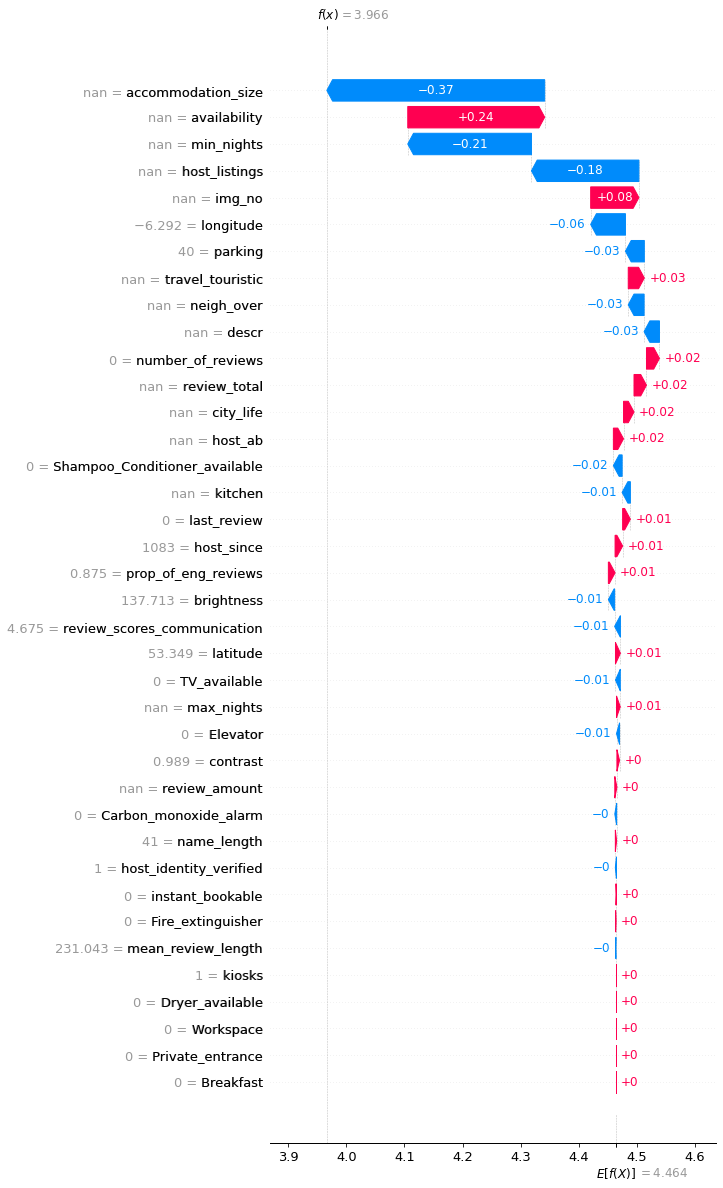

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[8], max_display = 50)

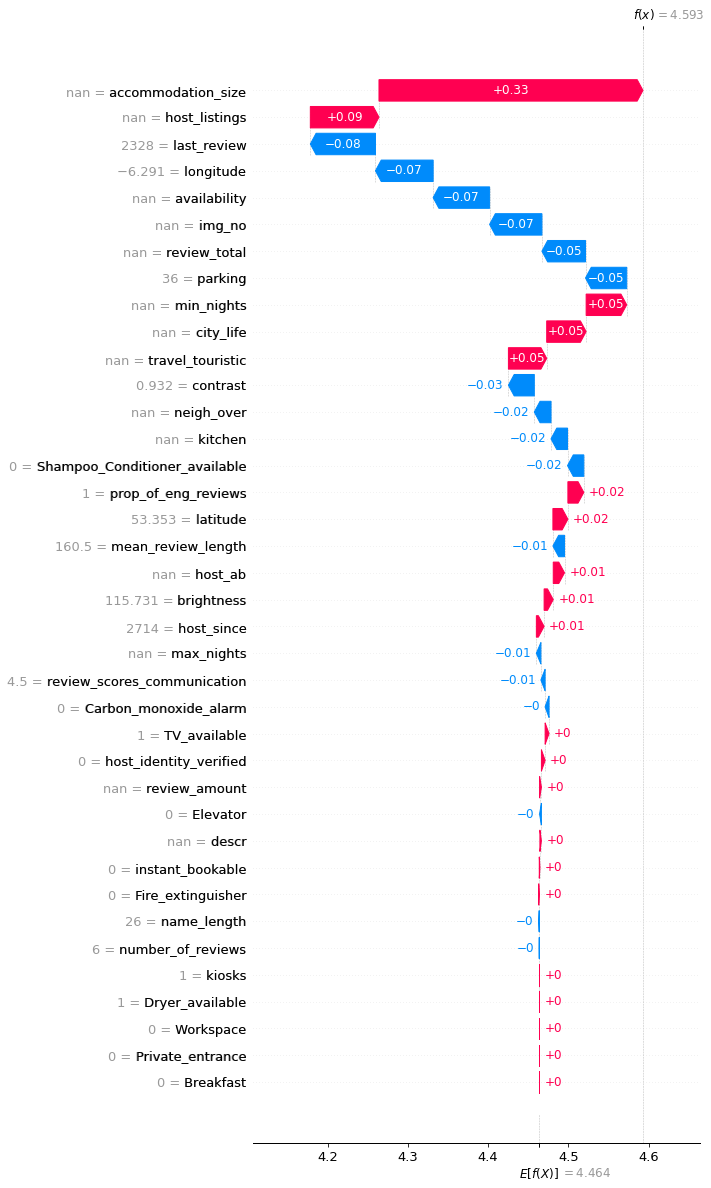

In [ ]:
explainer = shap.Explainer(model_fold)
shap_values = explainer(X_test)
shap_values = get_aggr_shap(shap_values)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[588], max_display = 50)

In [ ]:
X_test_no.shape

(1321, 149)

All-NaN slice encountered


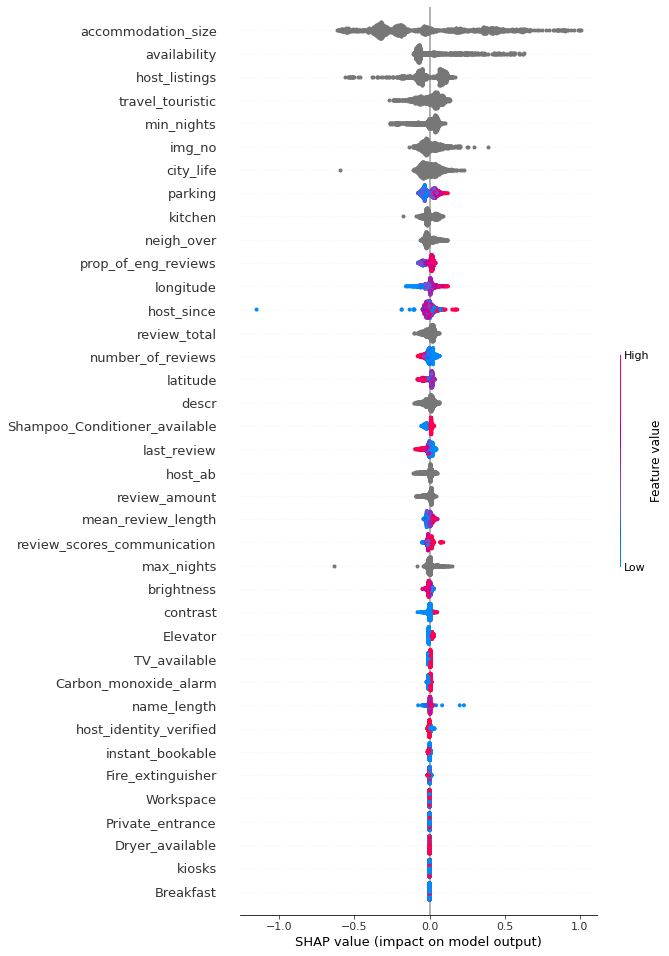

In [ ]:
shap.plots.beeswarm(shap_values, max_display=50)
